### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [5]:
from src.load_datasets import load_household_electricity_data


dataframe = (
    load_household_electricity_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(resample_data, freq="H")
    #.pipe(interpolate_column)
)

print(f"dataframe shape {dataframe.shape}")

#dataframe = dataframe[
#    ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)"]
#].copy(deep=True)

dataframe.head()

format_datetime: DF Shape (2075259, 8)
set_index: DF Shape (2075259, 7)
resample_Data: DF Shape (34589, 7)
dataframe shape (34589, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [6]:
dataframe.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [7]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.307192,-0.374436,0.999419,0.495645,0.439244,0.696104
Global_reactive_power,0.307192,1.000000,-0.141156,0.323322,0.325437,0.255332,0.099668
Voltage,-0.374436,-0.141156,1.000000,-0.387831,-0.204854,-0.160202,-0.273985
Global_intensity,0.999419,0.323322,-0.387831,1.000000,0.504097,0.446582,0.686321
Sub_metering_1,0.495645,0.325437,-0.204854,0.504097,1.000000,0.116226,0.195251
Sub_metering_2,0.439244,0.255332,-0.160202,0.446582,0.116226,1.000000,0.123952
Sub_metering_3,0.696104,0.099668,-0.273985,0.686321,0.195251,0.123952,1.000000


### Test Train split

train_xy and test_xy size: (34574, 7), (15, 7)

y_train and x_train size (34574,), (34574, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sub_metering_3'>)

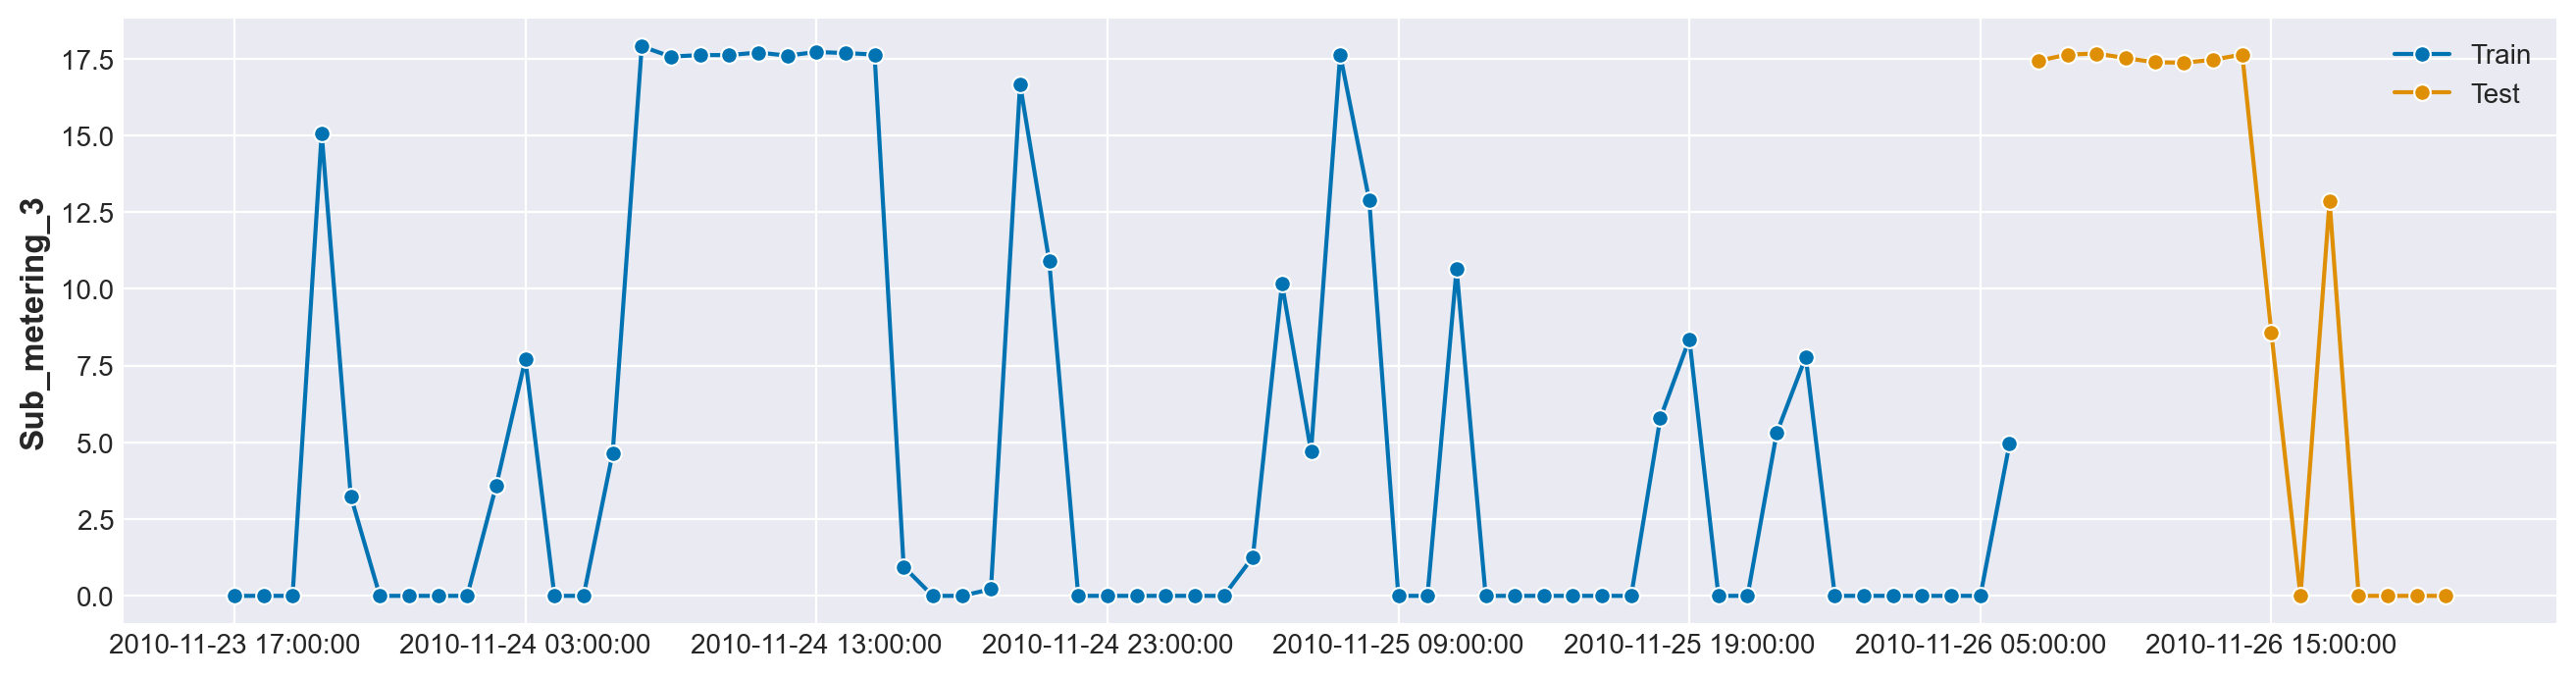

In [8]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "Sub_metering_3"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(62), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 34499 , step_length 15 for fold 5


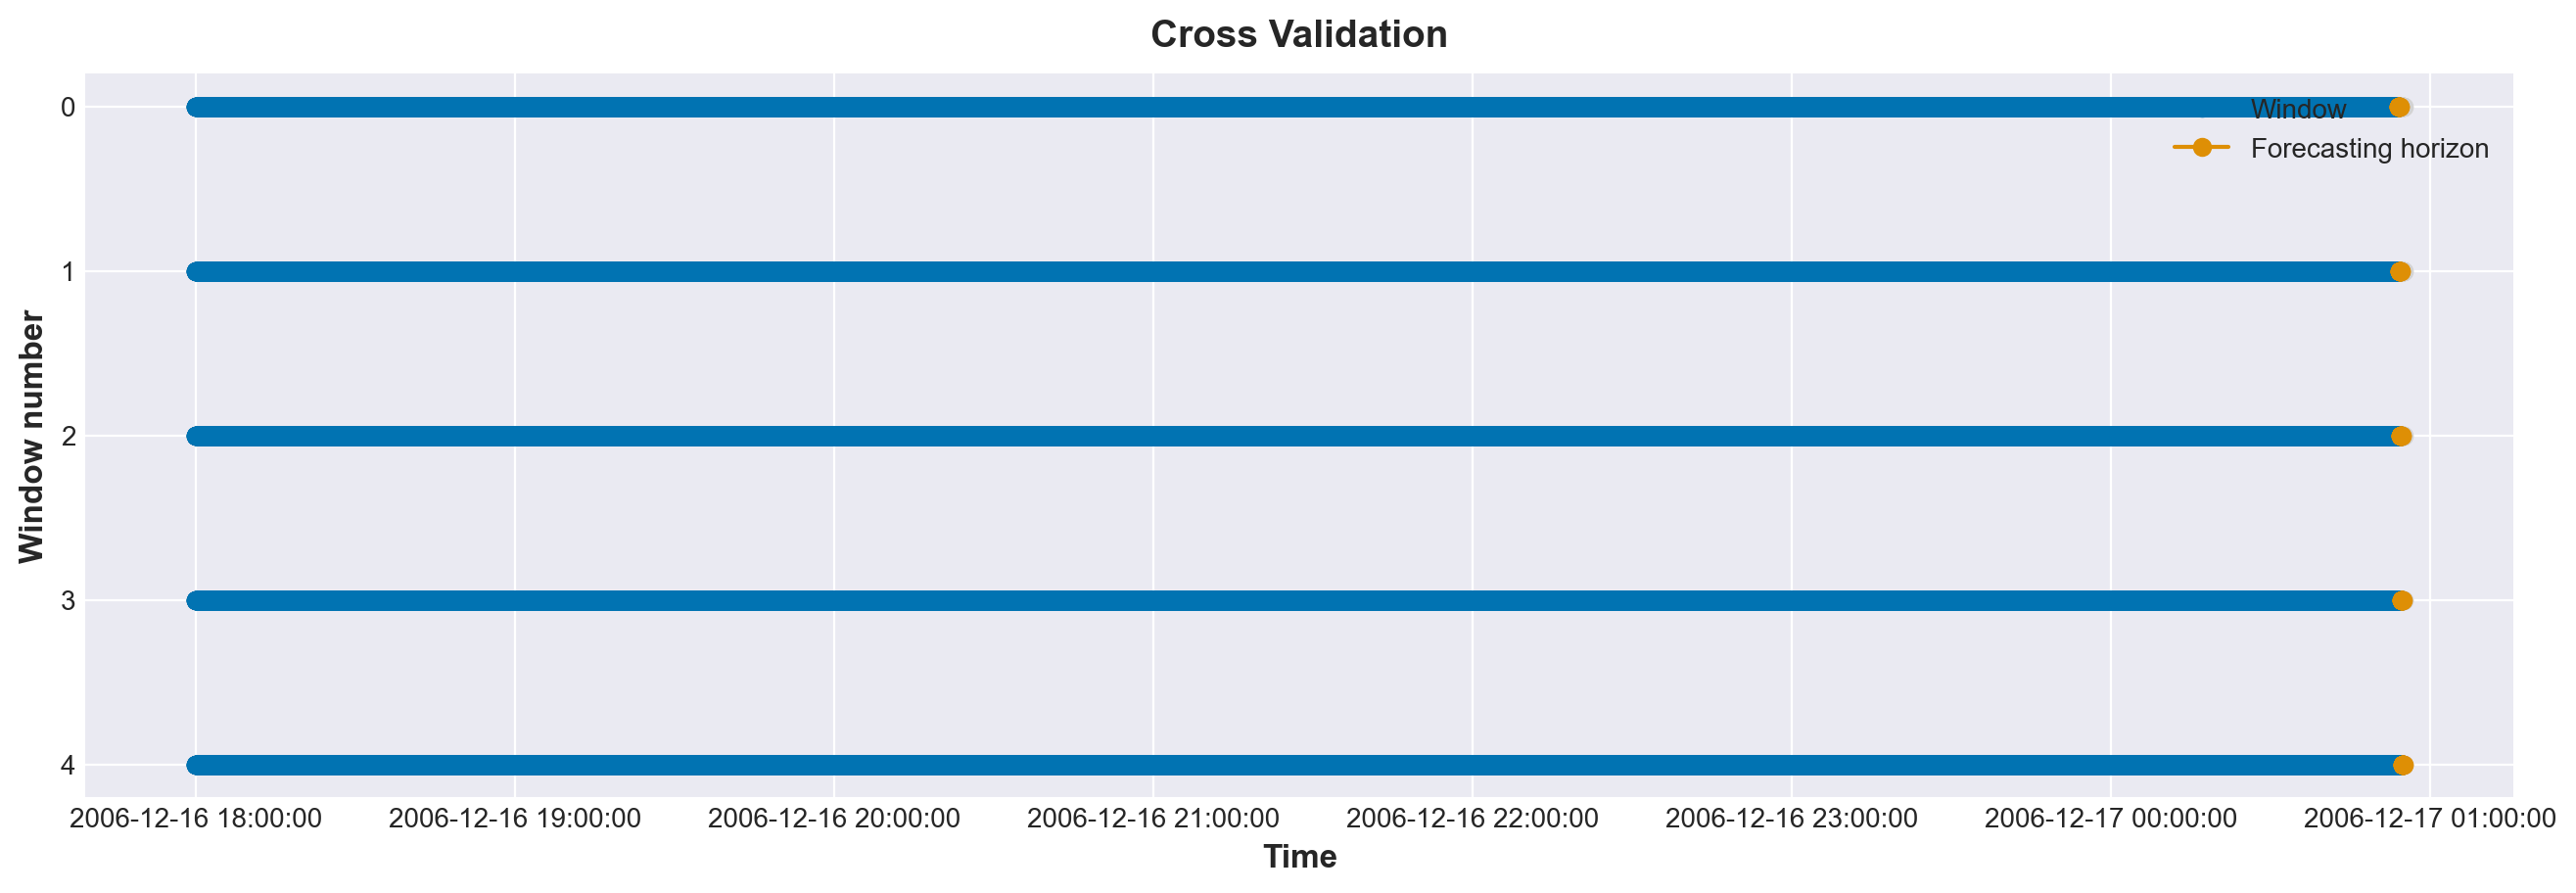

In [9]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [13]:
%%time

from sklearn.preprocessing import MinMaxScaler

try:
    from sklearnex.neighbors import KNeighborsRegressor

    print("Importing sklearnex KNeighborsRegressor")
except ImportError:
    from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError

param_grid = {
    # "forecaster__deseasonalizer__model": ["additive", "multiplicative"],
    "scaler_x__passthrough": [True, False],
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [24],
    "forecaster__reducer__estimator__n_neighbors": range(1, 51, 10),
    "forecaster__reducer__estimator__weights": ["uniform","distance"],
    "forecaster__reducer__estimator__metric" : ["minkowski", "euclidean", "manhattan"]
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        (
            "scaler_x",
            OptionalPassthrough(
                TabularToSeriesAdaptor(MinMaxScaler()), passthrough=False
            ),
        ),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=KNeighborsRegressor(),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsoluteError(),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best scores", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Importing sklearnex KNeighborsRegressor
Number of CPU Count:   12
Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 24, 'forecaster__detrender__forecaster__degree': 2, 'forecaster__reducer__estimator__metric': 'manhattan', 'forecaster__reducer__estimator__n_neighbors': 41, 'forecaster__reducer__estimator__weights': 'uniform', 'forecaster__reducer__window_length': 24, 'scaler_x__passthrough': True}
Best scores 3.896816038817864
CPU times: total: 9.44 s
Wall time: 5min 12s


In [14]:
print(x_test.columns)

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2'],
      dtype='object')


2010-11-26 07:00:00    13.101525
2010-11-26 08:00:00    12.113067
2010-11-26 09:00:00     7.286811
2010-11-26 10:00:00     7.007727
2010-11-26 11:00:00     9.067194
2010-11-26 12:00:00     5.707794
2010-11-26 13:00:00     3.271926
2010-11-26 14:00:00     1.631935
2010-11-26 15:00:00     1.500608
2010-11-26 16:00:00     2.410678
2010-11-26 17:00:00     4.126832
2010-11-26 18:00:00     6.037383
2010-11-26 19:00:00     5.980329
2010-11-26 20:00:00     7.303705
2010-11-26 21:00:00     7.047757
Freq: H, Name: Sub_metering_3, dtype: float64

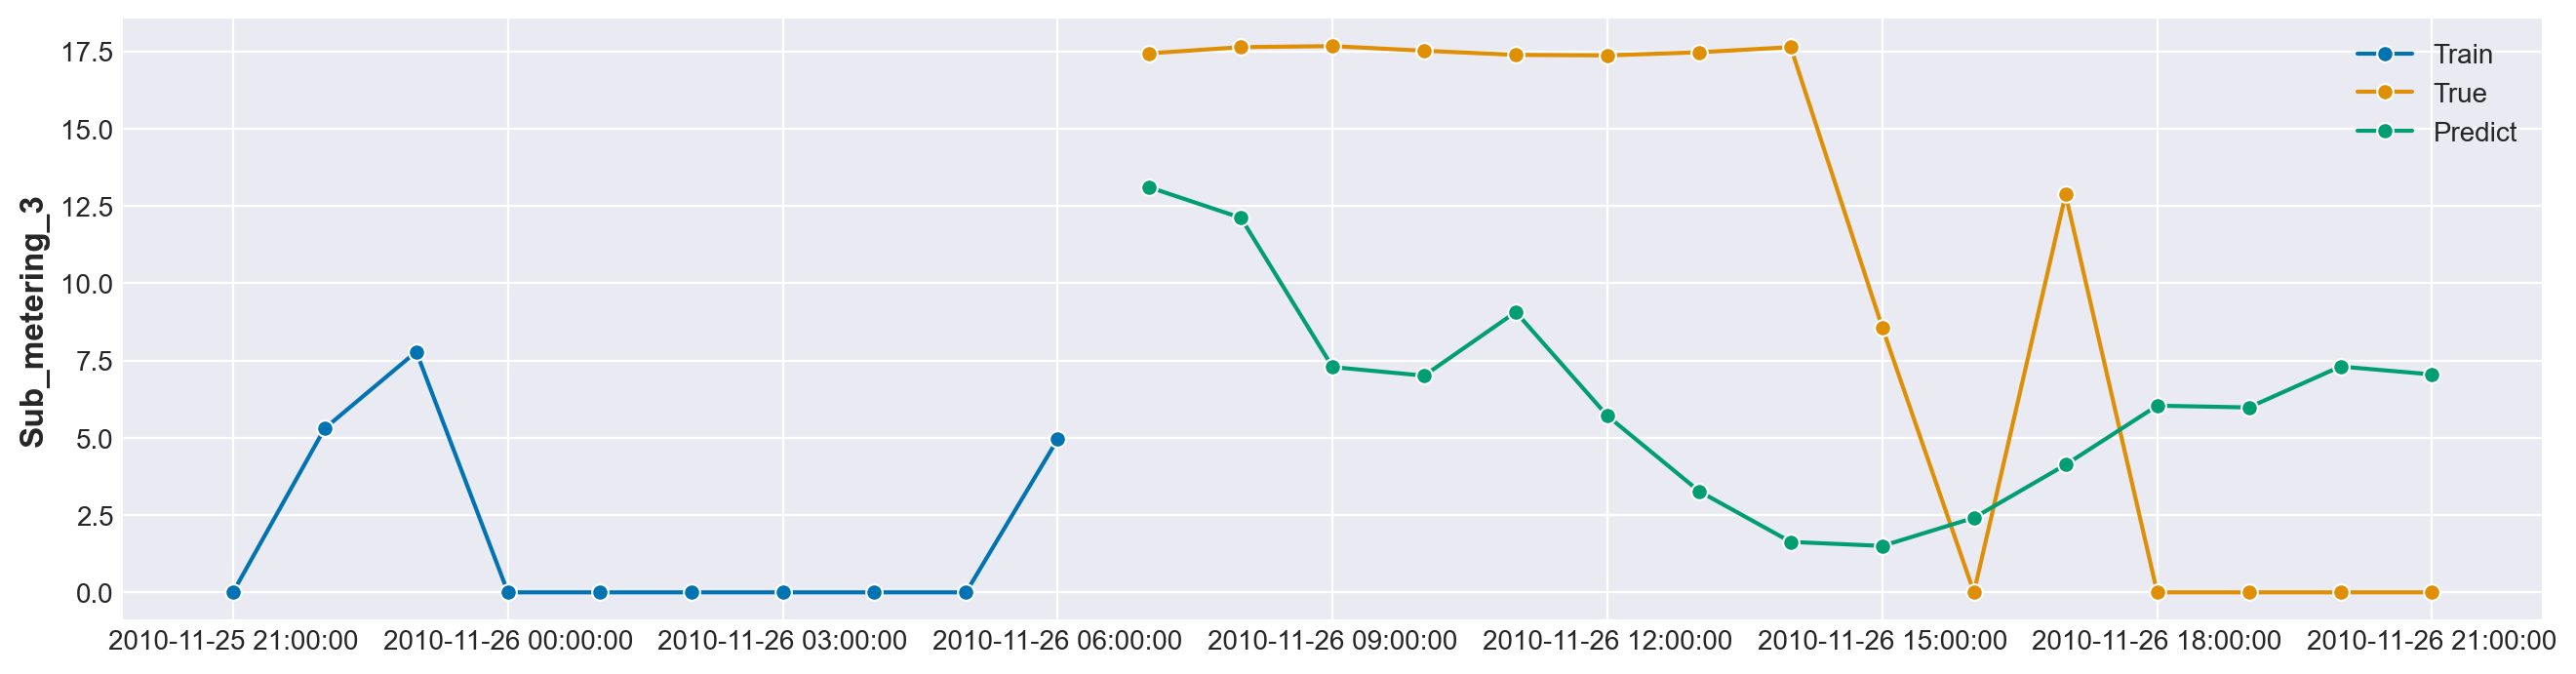

In [15]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [16]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(120, 5)


,mean_test_MeanAbsoluteError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsoluteError
0,5.443564,1.606065,3.327466,{'forecaster__deseasonalizer__model': 'additiv...,102.5
1,5.672477,1.713580,3.532706,{'forecaster__deseasonalizer__model': 'additiv...,110.5
2,5.443564,1.740936,3.349802,{'forecaster__deseasonalizer__model': 'additiv...,102.5
3,5.672477,1.757483,3.672739,{'forecaster__deseasonalizer__model': 'additiv...,110.5
4,4.223329,1.726297,3.229247,{'forecaster__deseasonalizer__model': 'additiv...,43.5


### Backtesting Insample Prediction

In [17]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
)

losses = [
    MeanSquaredError(),
    MeanSquaredError(square_root=True),
    MeanAbsoluteError(),
    MeanAbsolutePercentageError(),
    MeanAbsolutePercentageError(symmetric=False),
    MeanAbsoluteScaledError(),
]

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=losses,
    return_data=True,
)
results

,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,test_MeanAbsoluteScaledError
0,5.223392,5.043022,1.302511,34499,2010-11-23 03:00:00,2006-12-16 17:00:00 16.861111 2006-12-16 18...,Date_Time 2010-11-23 04:00:00 0.000000 201...,2010-11-23 04:00:00 1.485774 2010-11-23 05...,3.732587,1.087979e+16,1.030160
1,3.451355,4.921452,1.158789,34514,2010-11-23 18:00:00,2006-12-16 17:00:00 16.861111 2006-12-16 18...,Date_Time 2010-11-23 19:00:00 0.000000 201...,2010-11-23 19:00:00 8.827688 2010-11-23 20...,2.760181,6.988266e+15,0.761756
2,4.417605,5.019186,1.302166,34529,2010-11-24 09:00:00,2006-12-16 17:00:00 16.861111 2006-12-16 18...,Date_Time 2010-11-24 10:00:00 17.616667 201...,2010-11-24 10:00:00 16.694019 2010-11-24 11...,3.698366,5.320156e+15,1.020599
3,8.700156,4.845833,1.301073,34544,2010-11-25 00:00:00,2006-12-16 17:00:00 16.861111 2006-12-16 18...,Date_Time 2010-11-25 01:00:00 0.000000 201...,2010-11-25 01:00:00 1.342521 2010-11-25 02...,6.565063,2.283782e+16,1.811735
4,3.708248,5.170504,1.257079,34559,2010-11-25 15:00:00,2006-12-16 17:00:00 16.861111 2006-12-16 18...,Date_Time 2010-11-25 16:00:00 0.000000 2010...,2010-11-25 16:00:00 0.844815 2010-11-25 17:...,2.727883,7.164024e+15,0.752724


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Sub_metering_3'>)

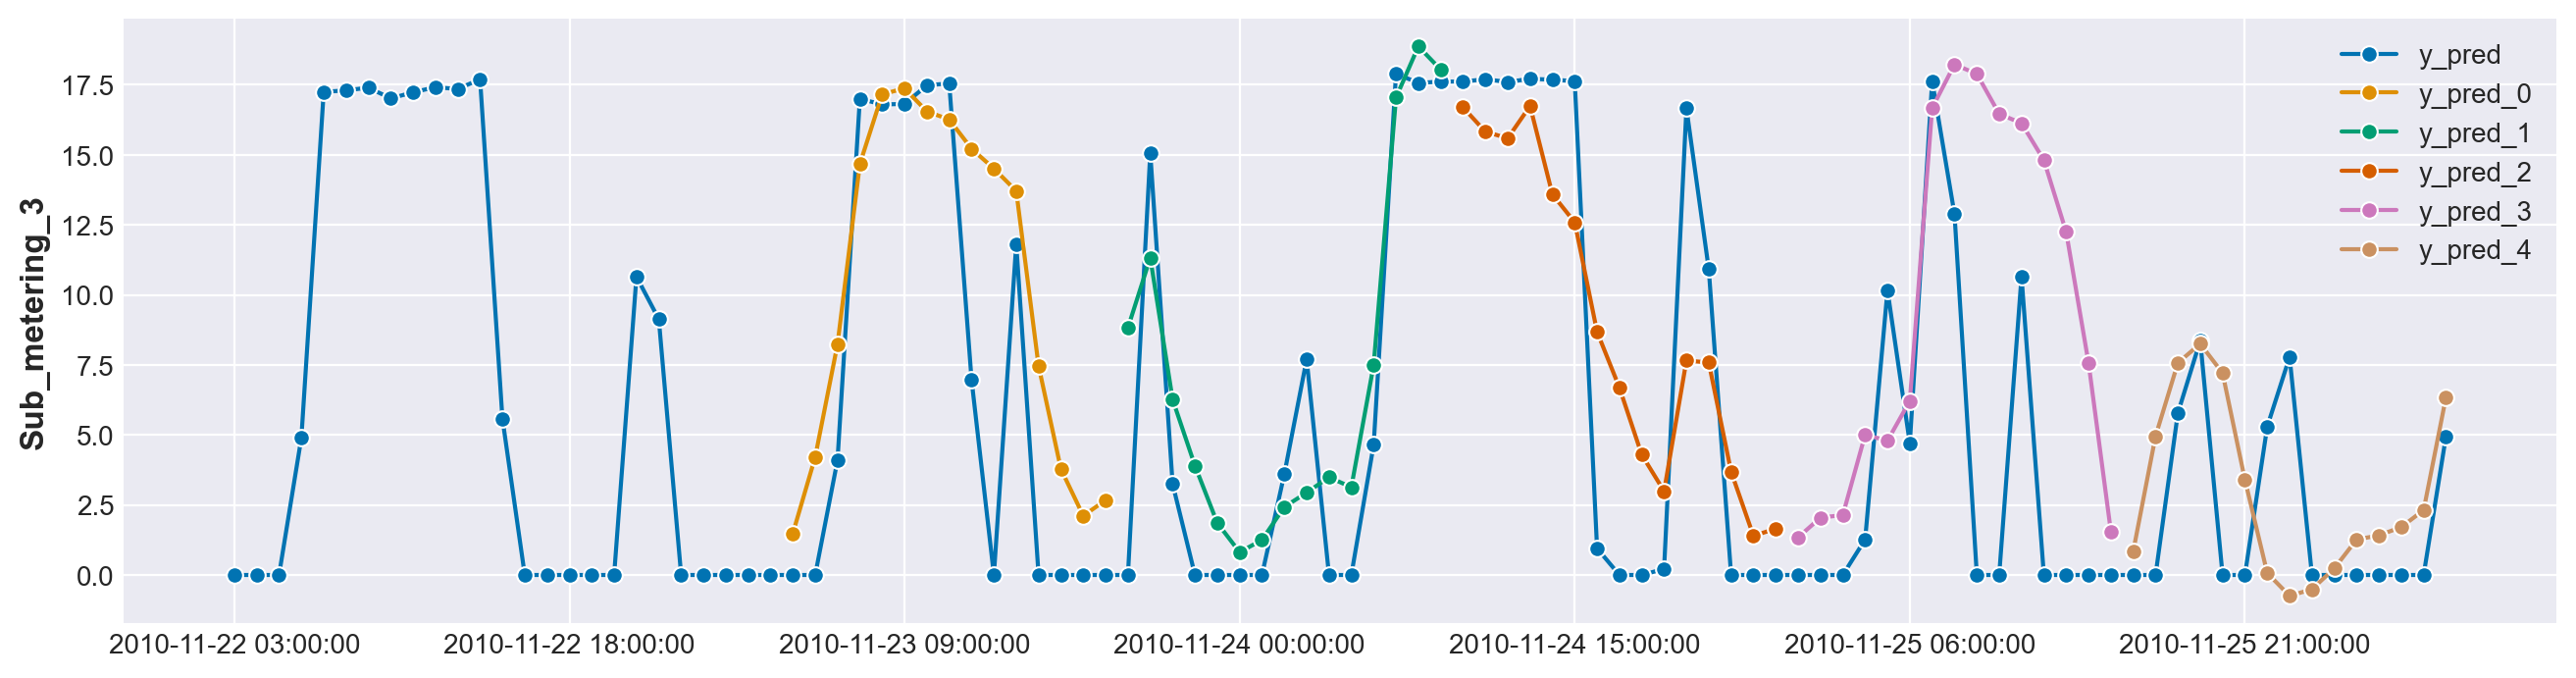

In [18]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [19]:
gscv.best_forecaster_.get_fitted_params()

{'forecaster': TransformedTargetForecaster(steps=[('imputer_y',
                                     Imputer(method='ffill', random_state=80)),
                                    ('deseasonalizer',
                                     ConditionalDeseasonalizer(sp=24)),
                                    ('detrender',
                                     Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
                                    ('reducer',
                                     RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(metric='manhattan', n_neighbors=41),
                                                                          pooling='global',
                                                                          window_length=24))]),
 'steps': [('x_transforner',
   TransformerPipeline(steps=[('imputer_x',
                               Imputer(method='ffill', random_state=80))])),
  ('scaler_x',
   OptionalPassthrough(passthrough=True,

### Train Model Parameter

In [21]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
#model_coeff = gscv.best_forecaster_.get_fitted_params()[
#    "forecaster__reducer__estimator__coef"
#]
#model_intercept = gscv.best_forecaster_.get_fitted_params()[
#    "forecaster__reducer__estimator__intercept"
#]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
#print(f"model_coeff {model_coeff}", end="\n\n")
#print(f"model_intercept {model_intercept}", end="\n\n")

model_n_features_in 30

model_fname_in ['Sub_metering_3_lag_1' 'Sub_metering_3_lag_2' 'Sub_metering_3_lag_3'
 'Sub_metering_3_lag_4' 'Sub_metering_3_lag_5' 'Sub_metering_3_lag_6'
 'Sub_metering_3_lag_7' 'Sub_metering_3_lag_8' 'Sub_metering_3_lag_9'
 'Sub_metering_3_lag_10' 'Sub_metering_3_lag_11' 'Sub_metering_3_lag_12'
 'Sub_metering_3_lag_13' 'Sub_metering_3_lag_14' 'Sub_metering_3_lag_15'
 'Sub_metering_3_lag_16' 'Sub_metering_3_lag_17' 'Sub_metering_3_lag_18'
 'Sub_metering_3_lag_19' 'Sub_metering_3_lag_20' 'Sub_metering_3_lag_21'
 'Sub_metering_3_lag_22' 'Sub_metering_3_lag_23' 'Sub_metering_3_lag_24'
 'Global_active_power' 'Global_reactive_power' 'Voltage'
 'Global_intensity' 'Sub_metering_1' 'Sub_metering_2']



### model cutoff

In [22]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

DatetimeIndex(['2010-11-26 06:00:00'], dtype='datetime64[ns]', name='Date_Time', freq='H') 2010-11-26 06:00:00


### Model Cloning

In [23]:
from sklearn.base import clone

model = clone(gscv.best_forecaster_).set_params(**gscv.best_params_)

dir(model)

['_X',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rpow__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_anytag_notnone_set',
 '_anytag_notnone_val',
 '_anytagis',
 '_anytagis_then_set',
 '_check_X',
 '_check_X_y',
 '_check_estimators',
 '_check_fh',
 '_check_names',
 '_check_steps',
 '_clone_flags',
 '_coerce_estimator_tuple',
 '_components',
 '_config',
 '_config_dynamic',
 '_converter_store_y',
 '_cutoff',
 '_dunder_concat',
 '_fh',
 '_fit',
 '_get_class_flag',
 '_get_class_flags',
 '_get_estimator_list',
 '_get_estimator_names',
 '_get_estimator_tuples',
 '_get_fitted_params',
 '_get_fitted_params_defa

### Model saving 

In [24]:
# gscv.best_forecaster_.save("../results/elastic_net")

import joblib

joblib.dump(gscv.best_forecaster_, "../results/Knn_model.pkl")

['../results/Knn_model.pkl']

### Features importance

In [25]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)

NameError: name 'model_coeff' is not defined